In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import torch.backends.cudnn as cudnn

from tqdm.notebook import tqdm

import wandb

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

if torch.cuda.is_available(): device = torch.device("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

In [3]:
wandb.init()
wandb.run.name = 'lstm'
wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qja1998. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [4]:
class GasDataset(Dataset):
    def __init__(self, df, seq_len, year=None):
        self.seq_len = seq_len

        self.df = df
        if year is not None:
            self.df = self.df.loc[self.df['year'] == year]
    
    def __len__(self):
        return len(self.df) - self.seq_len - 1

    def __getitem__(self, idx):
        data = self.df.iloc[idx:idx + self.seq_len]
        date, x = data.date, torch.from_numpy(np.array(data[['supply']], dtype=np.float32))
        y = torch.from_numpy(np.array(self.df.iloc[idx + self.seq_len, -4], dtype=np.float32))

        return x, y

In [5]:
#https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch5-CNN-LSTM.html
class TensorExtractor(nn.Module):
    def forward(self, x):
        tensor, _ = x
        return tensor
class ReshapeData(nn.Module):
    def __init__(self, seq_len, is_input=True):
        super(ReshapeData, self).__init__()
        self.seq_len = seq_len
        self.is_input = is_input
    def forward(self, x):
        if self.is_input:
            return x.unsqueeze(1)
        else:
            return x.squeeze(1)

    
class Model(nn.Module):
    def __init__(self, model_name, input_size, hidden_size, num_layer, conv=False, conv_size=1, kernel_size=2, stride=1, padding=0):
        super(Model, self).__init__()
        model_layers = []
        model_layers.append(nn.BatchNorm1d(input_size))
        if conv:
            conv = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)
            model_layers.append(ReshapeData(input_size, is_input=True))
            model_layers.append(conv)
            model_layers.append(ReshapeData(input_size, is_input=False))
            input_size = input_size - 1
        model_layers.append(nn.BatchNorm1d(input_size))
        if model_name == 'lstm':
            model_layers.append(nn.LSTM(input_size, hidden_size, num_layer))
        elif model_name == 'gru':
            model_layers.append(nn.GRU(input_size, hidden_size, num_layer))
        elif model_name == 'rnn':
            model_layers.append(nn.RNN(input_size, hidden_size, num_layer))
        model_layers.append(TensorExtractor())
        model_layers.append(nn.BatchNorm1d(hidden_size))
        model_layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*model_layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
seq_len = 30
train_rate = 0.8
df = pd.read_csv("data/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len)

model_name = 'lstm'
hidden_szie = 128
num_layers = 1
conv_size = 4

batch_szie = 256

model = Model(model_name, seq_len, hidden_szie, num_layers, conv_size).to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)

model.eval()
for batch_idx, (x, y) in enumerate(train_loader):
    x = x.squeeze(-1).to(device)
    y = y.unsqueeze(-1).to(device)
    print(x.shape, y.shape)
    output = model(x)

FileNotFoundError: [Errno 2] No such file or directory: 'data/kor_gas_day.csv'

In [ ]:
def train(model, train_loader, val_data, optimizer, criterion, epoch):
    model.train()
    for i in tqdm(range(epoch)):
        for batch_idx, (x, y) in enumerate(train_loader):
            x = x.squeeze(-1).to(device)
            y = y.unsqueeze(-1).to(device)
            
            optimizer.zero_grad()
            output = model(x)
            
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            wandb.log({
                "epoch": i,
                "Loss": loss,
                'x': x,
                'y': y
            })
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i, epoch,
                100. * i / epoch, loss.item()))

    if val_data is not None:
        model.eval()
        loss = 0
        true_val = []
        predictions = []
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(val_data):
                
                x = x.view(1, -1).to(device)
                y = y.unsqueeze(-1).to(device)
                output = model(x).squeeze(-1)

                loss += criterion(output, y)
                true_val.append(float(y.cpu().numpy()))
                predictions.append(float(output.cpu().numpy()))
        

        print('\nTest set: Average loss: {:.4f}'.format(loss / len(val_data)))
        
        plt.figure(figsize=(30,15))
        x = np.arange(len(true_val))
        plt.subplot(411)
        plt.plot(x, true_val, label='true', c='blue')
        plt.plot(x, predictions, label='predictions', c='red')
        plt.legend()

        true_val_cumsum = np.cumsum(true_val)

        tmp1 = predictions[:]
        for i, v in enumerate(true_val_cumsum[:-1]):
            tmp1[i + 1] = v + tmp1[i + 1]
            
        plt.subplot(412)
        plt.plot(x, true_val_cumsum, label='true', c='blue')
        plt.plot(x, predictions, label='predictions', c='red')
        plt.plot(x, np.cumsum(tmp1), label='self cumsum', c='orange')
        plt.legend()

        self_predictions = []
        x = val_data[0][0].view(1, -1).to(device)
        y = val_data[0][1].unsqueeze(-1).to(device)
        with torch.no_grad():
            for i, (_, true_y) in enumerate(val_data):
                output = model(x).squeeze(-1)
                tmp = x[0][1:].unsqueeze(0)
                x = torch.cat([tmp, output.unsqueeze(0)], dim=1)
                y = output

                loss += criterion(output, true_y.unsqueeze(-1).to(device))
                self_predictions.append(float(output.cpu().numpy()))

        print('\nTest set: Average loss: {:.4f}'.format(loss / len(val_data)))
        x = np.arange(len(true_val))
        plt.subplot(413)
        plt.plot(x, true_val, label='true', c='blue')
        plt.plot(x, self_predictions, label='predictions', c='red')
        plt.legend()
        
        tmp2 = self_predictions[:]
        for i, v in enumerate(true_val_cumsum[:-1]):
            tmp2[i + 1] = v + tmp2[i + 1]
        
        plt.subplot(414)
        plt.plot(x, true_val_cumsum, label='true', c='blue')
        plt.plot(x, self_predictions, label='predictions', c='red')
        plt.plot(x, np.cumsum(tmp2), label='self cumsum', c='orange')
        plt.legend()

        return true_val, true_val_cumsum, predictions, self_predictions

In [ ]:
seq_len = 21
train_rate = 0.8
df = pd.read_csv("data/kor_gas_day.csv")
df = df.loc[df['type'] == 'A']
df.loc[:, ['supply']] = df.loc[:, ['supply']].astype(float).diff()
df = df[1:]
train_len = int(len(df) * train_rate)

df_train, df_val = df.iloc[:train_len], df.iloc[train_len:]
train_dataset = GasDataset(df_train, seq_len)
val_dataset = GasDataset(df_val, seq_len)

In [ ]:
model_name = 'lstm'
hidden_szie = 128
num_layers = 3
learning_rate = 1e-3
conv = False

epochs = 500
batch_szie = 512

model = Model(model_name, seq_len, hidden_szie, num_layers, conv).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss().to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_szie, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_szie)

  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 500 [0/500 (0%)]	Loss: 18590.083984
Train Epoch: 500 [100/500 (20%)]	Loss: 3938.556641
Train Epoch: 500 [200/500 (40%)]	Loss: 2301.639404
Train Epoch: 500 [300/500 (60%)]	Loss: 1716.811279
Train Epoch: 500 [400/500 (80%)]	Loss: 1152.514526

Test set: Average loss: 24500.9961

Test set: Average loss: 55994.3906


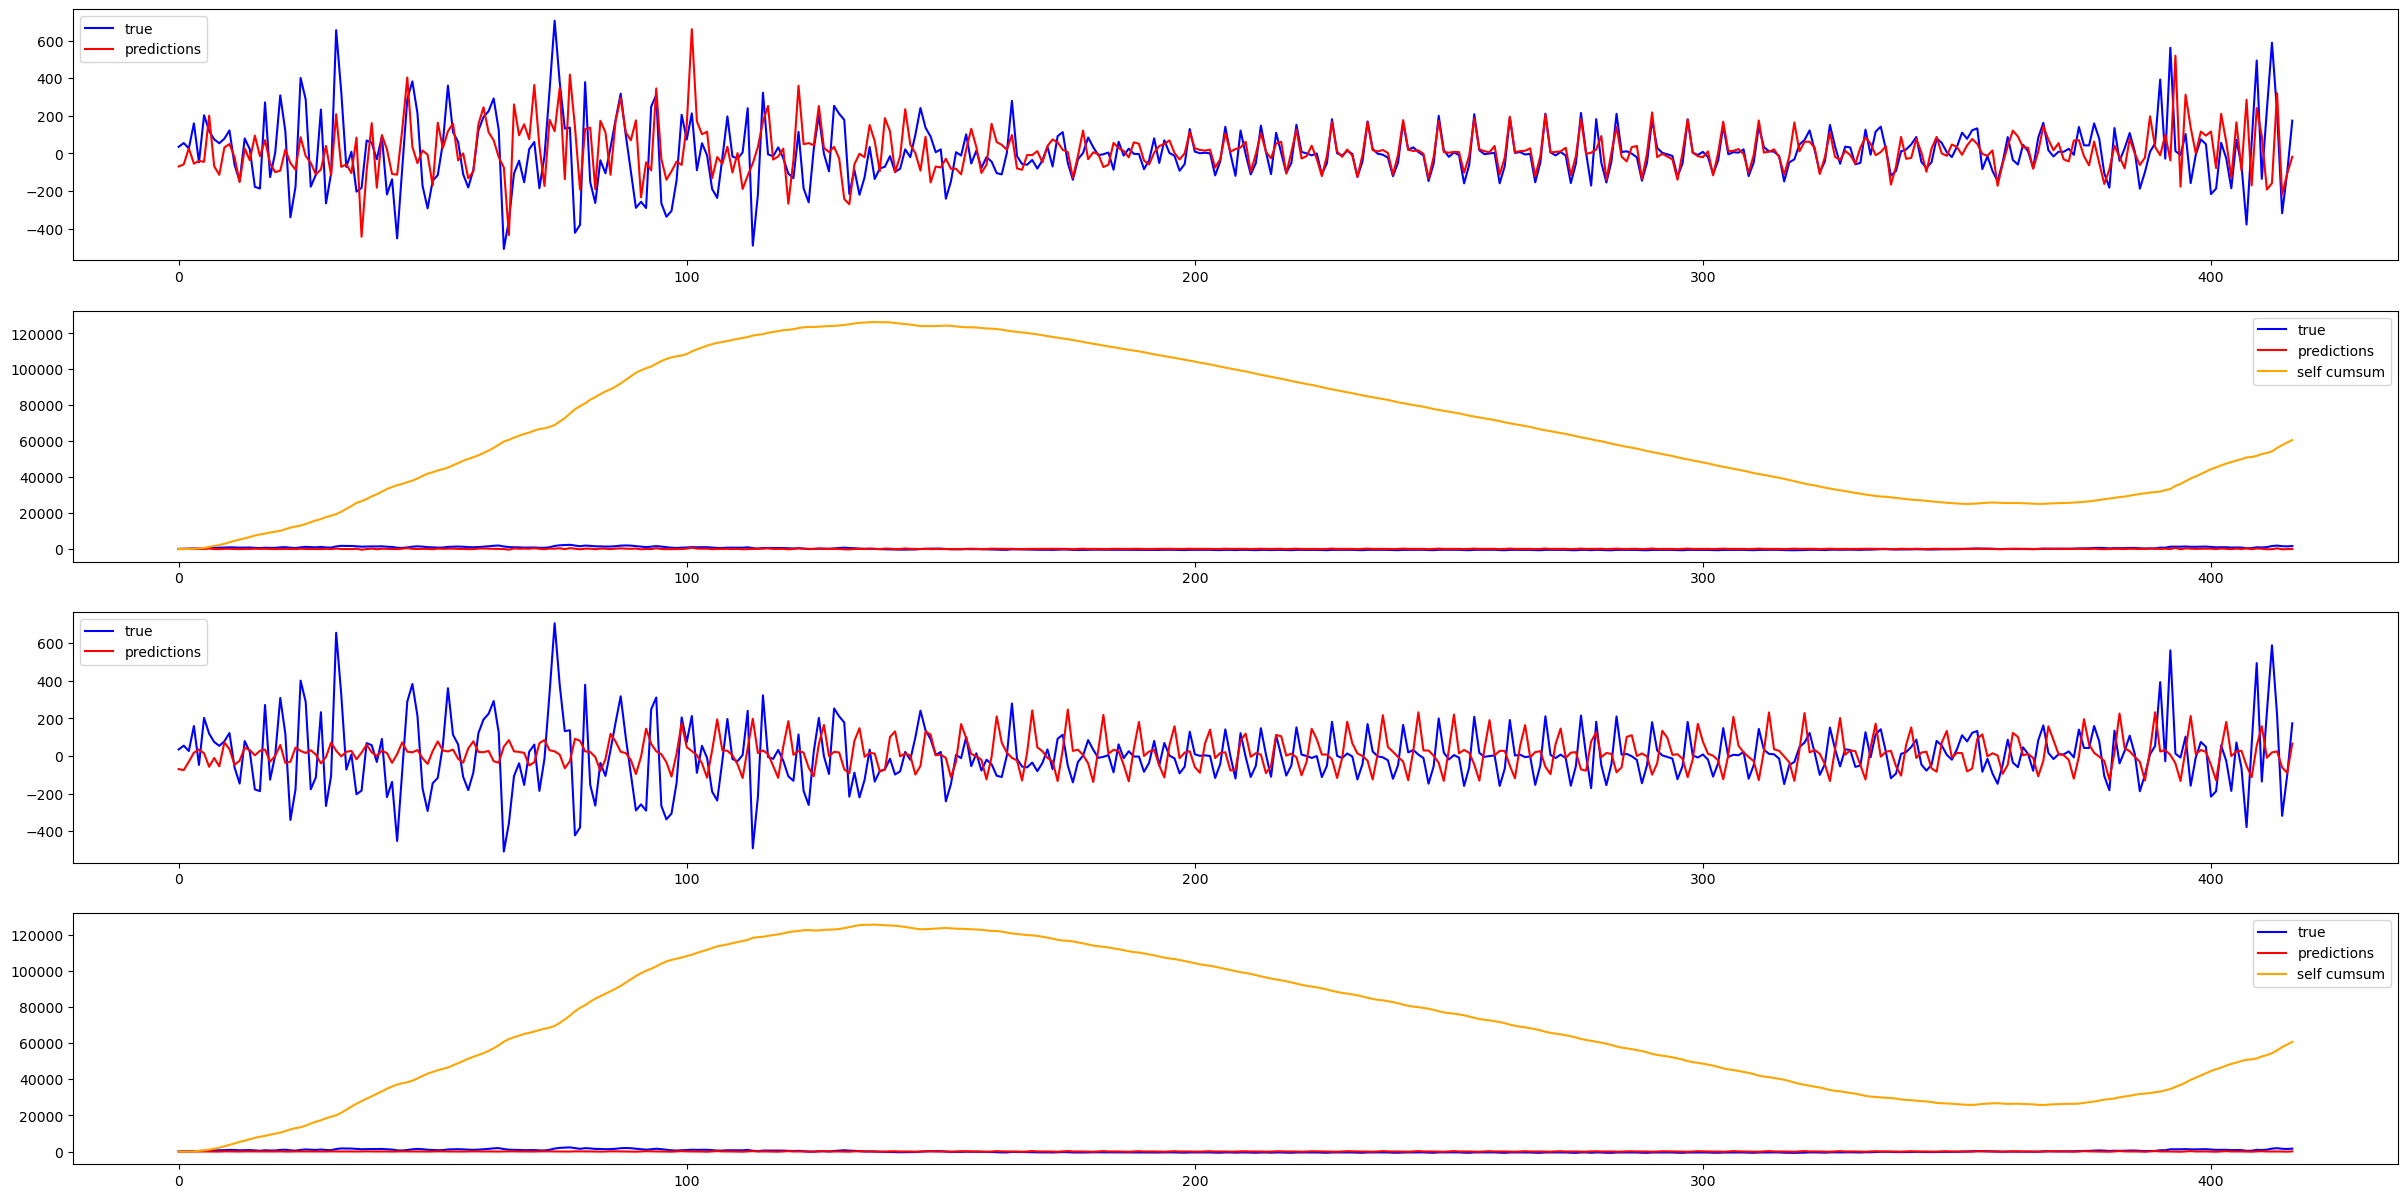

In [ ]:
results = train(model, train_loader, val_dataset, optimizer, criterion, epochs)
true_val, true_val_cumsum, predictions, self_predictions = results[:]